<a href="https://colab.research.google.com/github/mortenrosenloev/CPF_Final_Project/blob/main/CPF_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPF Algorithmic Trading - Final Project

================================================================================

## XGBoost-Based Evaluation of a Multi-Timeframe Strategy for EUR/USD Intraday Trading

================================================================================

#### Full Name: Morten Rosenløv Jensen

#### Submission Date: xx-05-2025

================================================================================

## Abstract

This project investigates a multi-timeframe approach to algorithmic trading, focusing on the EUR/USD currency pair. The primary objective is to reduce signal noise and minimize trading costs by executing trades only when predictive models across three distinct timeframes agree on the directional signal. The central hypothesis is that alignment across multiple temporal resolutions enhances entry signal quality, reduces false positives, and improves cost-efficiency. Furthermore, the study explores whether meta-labeling using the triple-barrier method proposed by Lopez de Prado [1] can further improve trade quality by filtering out noisy signals. The `XGBClassifier`, a tree-based ensemble machine learning model, is employed for this analysis.

## Introduction

Analyzing market movements across multiple timeframes is a common practice among swing and day traders [2, 3, 4]. Typically, the ratio between the individual timeframes ranges from 1:3 to 1:5. There are various ways to apply multi-timeframe analysis, including the use of indicators, support/resistance levels, and other technical methods.

In this study, we investigate the use of AI-based models (`XGBClassifier`) to predict the directional movement of the EUR/USD currency pair across three timeframes, with the goal of identifying high-quality entry and exit points for long and short positions. To the best of our knowledge, this specific use of AI models in a multi-timeframe framework has not been previously documented in the literature.

The three timeframes used in this study are:
1. 12h – 'trend': This prediction determines the overall market direction over the next 12 hours and defines the permissible trading direction (long or short).
2. 4h – 'signal': Trades are only permitted when the 'signal' prediction agrees with the 'trend'. If a trade is active, a change in the 4h signal also serves as an exit condition.
3. 1h – 'timing': This prediction is used for precise entry timing. A trade is entered only when all three models — 'trend', 'signal', and 'timing' — align in the same direction.

The predictions from these three timeframes are combined into a Multi-Timeframe Strategy (MTS), capable of taking long or short positions, or remaining neutral. As a final layer, we apply the triple-barrier meta-labeling technique proposed by Lopez de Prado [1] to further filter and validate trading signals.

## Content

1. Imports
2. Data Pre-Processing and Timeframe Comparison
3. The AI Model
4. Multi-Timeframe Strategy (MTS)
5. Meta-Labeling
6. Conclusion
7. Next Steps
8. References

## 1. Imports

### 1.a. Google Colab Installations Necessary to Run the Notebook

In [ ]:
# Google Colab: Install required packages
import os
import sys

if 'google.colab' in sys.modules:
    # Remove previous versions
    !pip uninstall -y numpy

    # Install compatible versions
    !pip install statsmodels
    !pip install numpy==1.23.5 pandas==2.2.3 pandas-ta==0.3.14b xgboost==3.0.0

    # Restart to ensure correct environment
    os.kill(os.getpid(), 9)

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 84.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    U

In [1]:
# Google Colab: Install required packages
import os
import sys

repo_url = 'https://github.com/mortenrosenloev/CPF_Final_Project.git'
repo_name = 'CPF_Final_Project'

# Get the current folder name
current_folder = os.path.basename(os.getcwd())

# Only clone if we are NOT already in the repo folder
if current_folder != repo_name and not os.path.exists(repo_name):
    !git clone {repo_url}

# Add src/ to path regardless of where we are
if current_folder == repo_name:
    src_path = os.path.join(os.getcwd(), 'src')
else:
    src_path = os.path.join(repo_name, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

### 1.b. Import Necessary Python Libraries and Modules

In [2]:
# Third-party
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from pylab import plt

# Own modules
from financial_data import FinancialData
from helper_functions import *
from data_pre_processing import DataPreProcessing
from xgb_training import XGBTraining
from meta_model_backtester import MetaModelBacktester

### 1.c. User Input

All user input are listed below with reference to the section it is introduced.

In [3]:
# GENERAL
seed = 100  # For reproducible results.
plt.style.use('seaborn-v0_8')  # Plot style used.

# SECTION 2. DATA PREPROCESSING AND TIMEFRAME COMPARISON.
symbol = 'EUR_USD'
start = '2020-07-01'
end = '2025-01-01'  # Covers all data until 2024-12-31 23:59:59.
base_url = 'https://raw.githubusercontent.com/mortenrosenloev/\
CPF_Final_Project/refs/heads/main/data/'

# Timeframes used for this study.
timeframes = {
    'trend': '12h',
    'signal': '4h',
    'timing': '1h'
}

bins = 6  # Used for 'bins' feature generation.
clusters = 8  # Used for 'regime' feature generation.
lags = 10  # Number of lags used for features.
normalize = None  # Not beneficial for the `XGBClassifier` (see section 3).
tt_split = '2024-07-01'  # Fixed train/test split date.

# SECTION 3. THE AI MODEL.
validation_split = 0.15  # Use 15% of the train data for model validation.
feat_ratio = 0.03  # Observations/features-ratio used for the AI model.
time_decay = 5e-6  # Rate of exponential time decay applied to sample weights.

# SECTION 5. META-LABELING.
lookahead = 24  # Timeout in bars if neither SL nor TP is hit.
tp_multiplier = 3  # ATR-multiplier for take-profit target.
sl_multiplier = 2  # ATR multiplier for stop-loss.

## 2. Data Pre-Processing and Timeframe Comparison

This study utilizes resampled OHLCV data at 15-minute intervals for the EUR/USD currency pair, covering the period from 2020-01-01 to 2024-12-31 (inclusive). The data was retrieved from the OANDA trading platform and saved as a CSV file in the designated url.

A custom `FinancialData` class was developed to handle the following preprocessing steps:
1. Resample the raw data to the desired timeframe.
2. Set the index using `label='right'`, ensuring that each timestamp corresponds to the closing time of the candle. This is critical to avoid data leakage and look-ahead bias when combining multiple timeframes.
3. Adjust timestamps to account for U.S. daylight saving time changes.
4. Align the data to start at market open, rather than midnight (which is the default in `pandas`).
5. Calculate trading costs, assumed to be equal to the bid/ask spread.

**Input Parameters to `FinancialData`:**
1. `url`: URL base path to CSV file.
2. `symbol`: ticker symbol from OANDA. In this study we only use 'EUR_USD'.
3. `timeframe`: Pandas-compatible resample frequency string (e.g., '1D', '1h') used for resampling the raw data.

To begin the analysis, we instantiate a separate `FinancialData` object for each of the three timeframes under investigation (12h, 4h, and 1h), enabling direct comparison of market behavior across different temporal resolutions.

In [4]:
# Create a dictionary (fd: financial data)
# containing resampled price data for each timeframe (tf).

fd = {}
for tf in timeframes:
    fd[tf] = FinancialData(
        base_url,
        symbol=symbol,
        timeframe=timeframes.get(tf)
    )

### 2.a. Histogram and QQ-plot of the Log-Returns

To explore the distribution of log-returns across the three timeframes, we use the functions `plot_histogram` and `plot_qq` from the `helper_functions` module. These functions generate histograms and quantile-quantile (QQ) plots of the log-returns for each timeframe: trend (12h), signal (4h), and timing (1h).

The plotting functions are designed to be generic and support optional data normalization. However, since we use a tree-based model (`XGBClassifier`), normalization of features is not necessary or beneficial [see Section 3]. Therefore, we do not further explore normalization effects in this study.

The plots are shown below, using no normalization on the log-returns.

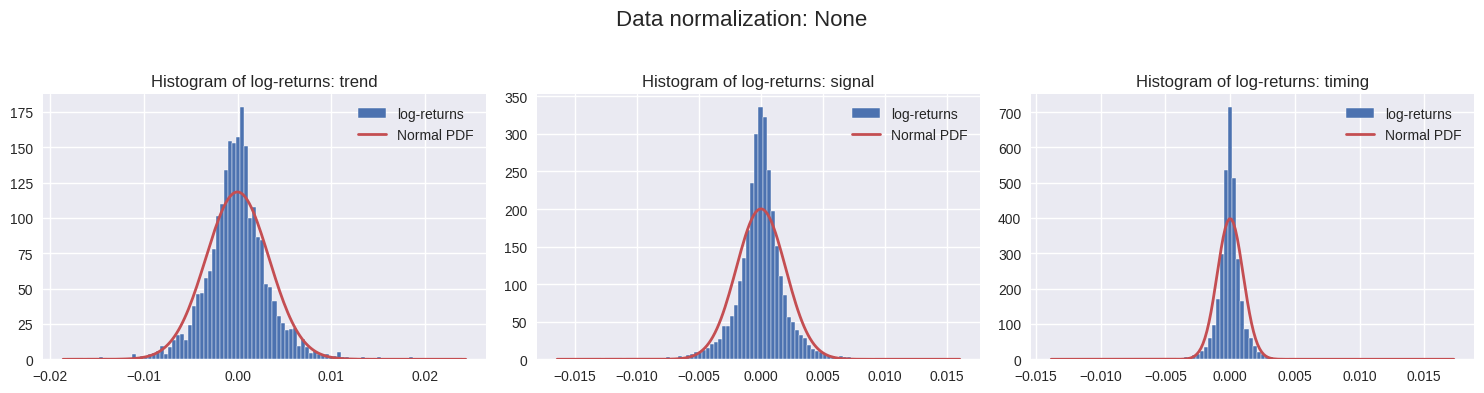

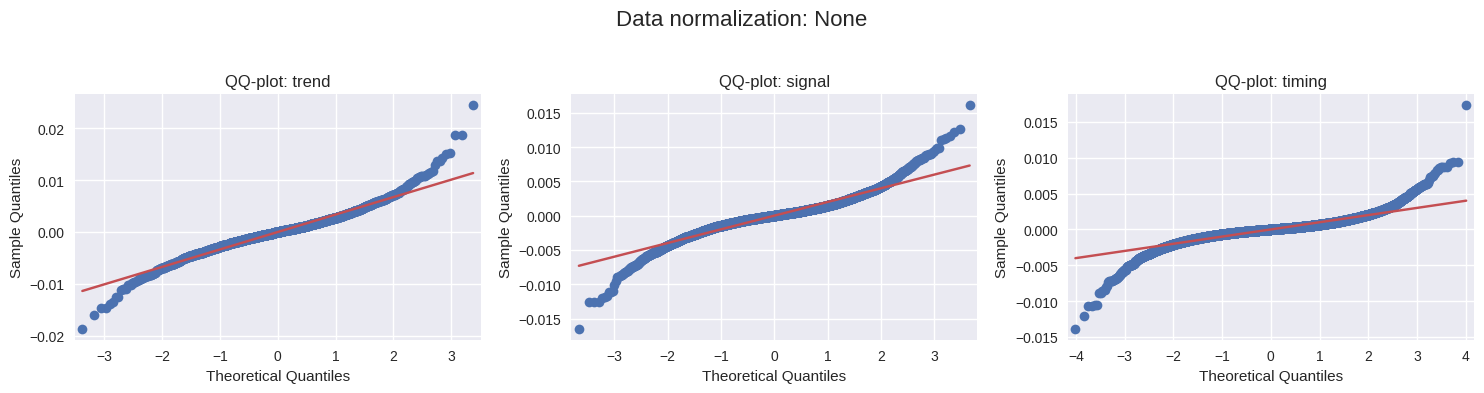

In [5]:
plot_histogram(fd, norm=None)
plot_qq(fd, norm=None)

**OBSERVATIONS:**  
1. All three timeframes show log-return distributions that deviate from normality, with a pronounced peak near zero and fat tails. This is evident in both the histograms and QQ-plots.
2. The longer the timeframe, the wider the return distribution becomes — as seen in the leftmost histogram (trend / 12h). This reflects the natural accumulation of price changes over time.
3. The QQ-plots confirm this difference in scale: the steeper the slope, the wider the return distribution.

Although this study does not attempt to quantify predictability across timeframes, we can hypothesize that shorter timeframes (e.g., 1h), with their tighter distributions and many small, near-zero returns, may contain more noise, making directional prediction more difficult. Conversely, longer timeframes (e.g., 12h) may offer a better signal-to-noise ratio due to the prevalence of larger price movements, which may be easier for a model to capture.

While this remains a hypothesis, it helps motivate the use of multiple timeframes in the combined model, each serving a different role in the trading decision logic.

### 2c. Data Pre-Processing

A custom class `DataPreProcessing` has been developed with the intent of supporting a wide range of pre-processing options to suit different types of models and analyses. In this section, we will outline the main capabilities of this class and highlight the subset of features relevant to this study.

The `DataPreProcessing` class inherits from the `FinancialData` class introduced earlier and builds training and testing datasets for machine learning applications. It is designed to be versatile and supports various configurations — including multiple normalization techniques — although normalization will not be used in this study, as it offers no benefit for the tree-based `XGBClassifier` model.

**Key Methods of the `DataPreProcessing` Class:**
1. `_add_features`: Performs feature engineering by incorporating a wide range of classic financial indicators, including trend, momentum, volatility, price-action, volume, and calendar-based features. Many of these are calculated using the `pandas_ta` library. It also includes derivatives such as changes, slopes, and cross-feature relations.
2. `_create_splits`: Splits the dataset into training and test sets. This can be done using either a fixed fraction (e.g., 0.8) or a specific split date (e.g., '2024-07-01').
3. `_normalize` and `_automatic_scaler_selection`: Supports five normalization strategies (standard, robust, quantile, min-max, and auto). The auto option selects the most appropriate scaler per feature based on its statistics. These are not used in this study.
4. `_add_bins_regime`: Add bins based on the quantile distribution of the log-returns and applies `KMeans` clustering to a subset of selected features to group the data into distinct market regimes. Both bins and the resulting regime label are added as features.
5. `_add_lags`: Introduces lagged features to prevent data leakage and foresight bias. Only lagged versions of the features are used for model training. Calendar features are lagged once only, as further lags do not provide additional information due to their cyclical nature.
6. `plot_KMean`: Optional function that plots the inertia score vs. the number of clusters used in the _add_bins_regime method (this plot will be shown later).

**Input Parameters to `DataPreProcessing`:**  
In addition to the input from the `FinancialData` class, `DataPreProcessing` takes the following arguments:
1. `start`: Start date (inclusive) for the dataset.
2. `end`: End date (exclusive). All data up to, but not including, this date is included.
3. `bins`: Number of bins for the `_add_bins_regime` method.
4. `clusters`: Number of clusters/regimes to use.
5. `lags`: Number of lags to apply to each feature.
6. `normalize`: Normalization method to apply to the input features (None in this study).
7. `tt_split`: Fraction or specific date to split the data into train/test sets. If a date is used, the first test-set data point corresponds to the split date.

**Study-Specific Setup**  
In this study, we use a single fixed train/test split. While in a production setting it would be more appropriate to retrain models continuously — for instance, using a rolling window approach with the split moving forward one month at a time — we omit this due to computational cost.



**i) Create a Dictionary of Pre-Processed Data for Each Timeframe**

In [6]:
# pp (pre-processing) dictionary to contain data for each timeframe (tf)
pp = {}

for tf in timeframes:
    pp[tf] = DataPreProcessing(
        base_url,
        symbol, start=start,
        end=end,
        timeframe=timeframes.get(tf),
        bins=bins,
        clusters=clusters,
        lags=lags,
        normalize=None,
        tt_split=tt_split
    )

**ii) Rationale for Clusters = 8**

The number of clusters was set to 8, as the elbow plot of the `KMeans` clustering algorithm indicates a clear inflection point before that value (see plot below):

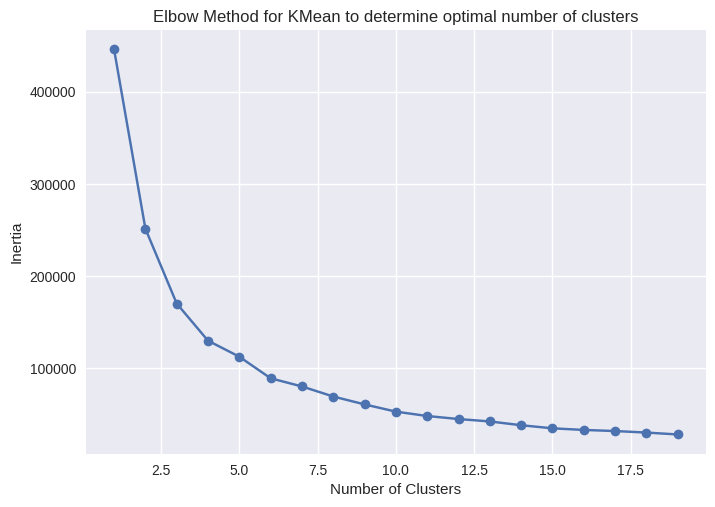

In [7]:
pp['trend'].plot_KMean()

## 3. The AI Model

### 3.a. Short Model Description

In this study, we use the XGBoost Classifier (`XGBClassifier`) as the machine learning model to predict the expected directional movement (up/down) of the next candle.

`XGBClassifier` is a high-performance gradient boosting ensemble model based on decision trees. It builds trees sequentially, where each new tree attempts to correct the errors of the previous ones. Because it relies on the relative ordering and thresholds of feature values (e.g., N > 5), normalizing the features is generally not recommended, as it may distort the feature relationships.

Using the previously described `DataPreProcessing` class, it is straightforward to evaluate the effect of normalization. It was tested and confirmed that the model performs better on non-normalized feature sets, which is the approach adopted throughout this study.

Beyond accuracy, training efficiency is also a key consideration. Since this study involves numerous training loops, the relatively fast training time of `XGBClassifier` compared to other models is another reason for its selection.

**Key Hyperparameters in `XGBClassifier`**  
A dedicated training class, `XGBTraining`, has been developed to manage the training process. It supports manual parameter setting as well as optional hyperparameter tuning using `RandomizedSearchCV`. Below are the most important hyperparameters:
1. `n_estimators`: Number of trees in the ensemble.
    - Too low → underfitting; too high → overfitting.
2. `max_depth`: Maximum depth of each tree.
    - Lower values generalize better; higher values risk overfitting.
3. `learning_rate`: Step size shrinkage applied to each tree.
    - Balances model convergence and stability.
4. `subsample`: Fraction of training data used per tree.
    - Values <1 act as a regularizer and help prevent overfitting.
5. `colsample_bytree`: Fraction of features considered per tree.
    - Helps increase diversity among trees and reduce overfitting risk.
6. `reg_alpha`: L1 regularization term.
    - Encourages sparsity and helps reduce model complexity.
7. `reg_lambda`: L2 regularization term.
    - Penalizes large weights and improves generalization.

### 3.b. Model Training and Optimization

**Key Methods of the `XGBTraining` Class:**
1. `_create_validation_data`: Optional method that takes a user-defined fraction of the training data to create a validation set for early stopping.
2. `_select_top_n_features`: Optional method to reduce the number of input features used by the model, based on their importance measured by `gain`.
3. `_optimize_hyperparams`: Optional method using `RandomizedSearchCV` to find optimal hyperparameters.
4. `_fit_perform`: Trains and tests the model with the chosen hyperparameters and feature set.
5. `_performance_metrics`: Calculates and prints (if `verbose=True`) performance metrics on training, validation, and test sets.
6. `_strategy_results` (including helper `_calculate_strategy_results`): Calculates the trading strategy returns with and without trading costs.
7. `plot_performance`: Generates plots of the strategy performance (with and without trading costs) compared to a buy-and-hold benchmark.
8. `plot_confusion_matrix`: Produces a confusion matrix plot along with a classification report.

**Input Parameters to `XGBTraining`:**  
1. `X_train`, `y_train`, `X_test`, `y_test`: Typically prepared by the `DataPreProcessing` class.
2. `returns`: Log-return values per bar, used for calculating strategy performance.
3. `tc`: Trading cost, used to adjust strategy returns.
4. `model`: An instantiated `XGBClassifier` model.
5. `validation_split`: Optional but recommended; fraction of training data reserved for validation to enable early stopping.
6. `top_n_features`: Option to limit the model to the most important features.
7. `optimize_hyperparameters`: Boolean flag to enable hyperparameter optimization.
8. `scoring`: Scoring metric used during hyperparameter optimization.
9. `time_decay`: Optional parameter to apply time-decay weighting, giving less importance to older data points.
10. `seed`: Optional random seed for reproducibility.
11. `verbose`: If `True`, prints detailed model performance metrics and hyperparameter optimization results.

It is generally observed that using a validation split helps prevent overfitting, and that the model achieves better performance when early stopping is applied during training.

### 3.c. Model Training for Each Timeframe

To enable a meaningful comparison across the three timeframes ('trend', 'signal' and 'timing'), we apply a fixed train/test split:
- Training period: 01-07-2020 to 30-06-2024
- Test period: 01-07-2024 to 31-12-2024

Each model is trained and evaluated separately for each timeframe through the following steps:

1. Train/Test Split: The training and test datasets are retrieved from the `pp` dictionary, which contains pre-processed data for each timeframe [ref section 2.].
2. Model Initialization: A base `XGBClassifier` model is instantiated using default parameters.
3. Feature Selection: The top features are selected based on their `gain` importance. To mitigate the risk of overfitting and reduce computation time, we use a `feat_ratio` of 3%, meaning we include 3 features per 100 observations, with a maximum of 524 features.
4. Hyperparameter Optimization: The model's key hyperparameters are optimized using `RandomizedSearchCV`.
5. Model Training: The model is trained on the training data and evaluated on the test set.
6. Strategy Evaluation: Performance metrics are calculated, including both classification scores and strategy returns, with and without trading costs (assumed to equal the bid/ask spread).
7. Visualization: The performance of each model is plotted and benchmarked against a simple buy-and-hold strategy.


Timeframe: trend 
--------------------
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found:
{'subsample': 0.4, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
--------------------------------------------------------------------------------------
TRAINING (IN-SAMPLE) METRICS:
accuracy: 0.6074 | precision: 0.6085 | recall: 0.6074 | f1: 0.6067 | roc_auc: 0.6077 | 
--------------------------------------------------------------------------------------
VALIDATION METRICS:
accuracy: 0.5481 | precision: 0.5482 | recall: 0.5481 | f1: 0.5480 | roc_auc: 0.5482 | 
--------------------------------------------------------------------------------------
TEST (OUT-OF-SAMPLE) METRICS:
accuracy: 0.5019 | precision: 0.5019 | recall: 0.5019 | f1: 0.5018 | roc_auc: 0.5018 | 
--------------------------------------------------------------------------------------


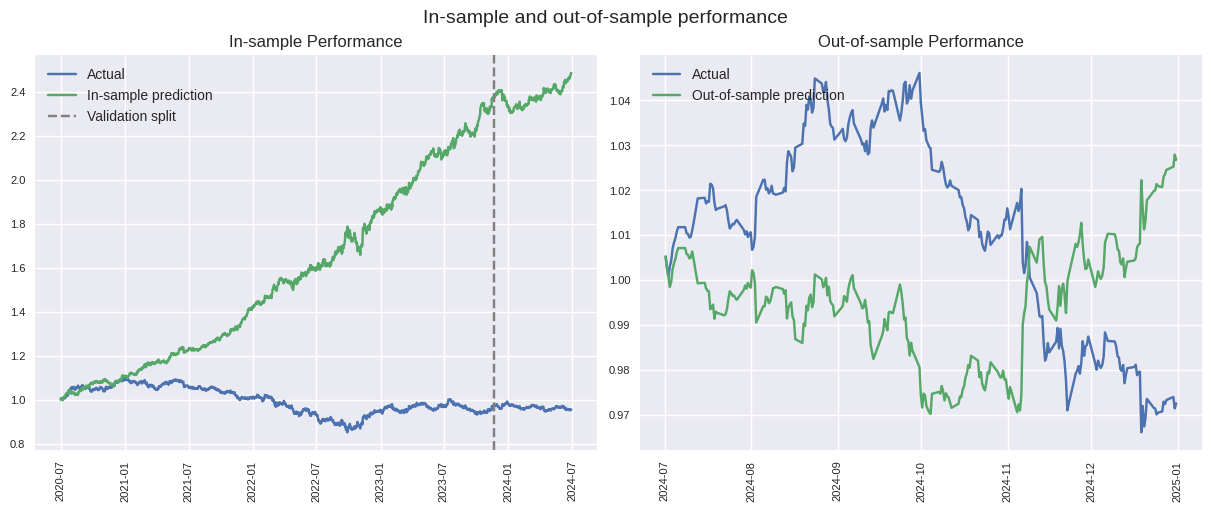


Timeframe: signal
--------------------
Fitting 4 folds for each of 25 candidates, totalling 100 fits


In [ ]:
tc = pp[tf].tc  # Trading cost is independent of the timeframe used

tf_model_results = {}  # Dictionary for the trained model object

for tf in timeframes:
    # Get the timeframe value from the dictionary
    value = timeframes.get(tf)

    # Print the header for the iteration
    print(f'\nTimeframe: {tf.ljust(6)}')
    print(20 * '-')

    # Set train/test-data for each DataFrame
    X_train = pp[tf].X_train
    y_train = pp[tf].y_train
    X_test = pp[tf].X_test
    y_test = pp[tf].y_test
    returns = pp[tf].data['r']

    # Instantiate an `XGBClassifier` model using default values
    model = create_model(random_state=seed)

    # Set the number of features to be used based on number of observations
    top_n_features = min(int(feat_ratio * len(X_train)), X_train.shape[1])

    # Calling the `XGBTraining`class for each timeframe (tf):
    tf_model_results[tf] = XGBTraining(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        tc=tc,
        returns=returns,
        model=model,
        validation_split=validation_split,
        optimize_hyperparameters=True,
        scoring='recall',
        top_n_features=top_n_features,
        time_decay=time_decay,
        seed=seed,
        verbose=True
    )

    # Plot performance
    tf_model_results[tf].plot_performance()

**OBSERVATIONS:**  
The results reveal clear differences between timeframes. For instance, the model trained on the trend timeframe achieves an out-of-sample recall of 0.5019, while the signal and timing models show slightly lower performance. This supports the hypothesis that longer timeframes may contain more predictable directional signals, possibly due to reduced noise and more persistent trends.

It is important to note that we focus solely on the directional prediction (up/down) of the next candle and not the size of the move. As such, precision and recall in this binary classification task are the most relevant metrics. While the test metrics are only marginally above random (≈0.5), even small predictive edges can be meaningful in a trading context—particularly when combined with cost-aware strategy design.  

It should be emphasized that the results shown here represent only one possible run with a specific random seed, train/test split, and hyperparameter configuration. In practice, repeated runs with different seeds or slightly shifted split dates may yield significantly different outcomes—particularly for the shorter timeframes, where data variability is higher and the signal-to-noise ratio is lower. Thus, no strong or consistent pattern can be concluded from these results alone, and further robustness checks would be required in a production setting.

Below, we plot the performance of the three models with and without trading cost and compare them to a buy-and-hold benchmark. A custom helper function, `plot_strategy_returns`, is used to generate the plots, as this visualization will also be applied in the comparative analysis in the following sections.

In [ ]:
fig, ax = plot_strategy_returns(
    tf_model_results,
    timeframes,
    lw=2.0,
    alpha=1.0,
    include_baseline=True
)

**OBSERVATIONS:**  
The 'trend' and 'signal' models outperform the buy-and-hold benchmark during the test period when trading costs are not considered. The plot on the right highlights how trading costs significantly impact overall performance—particularly for shorter timeframes, where trading frequency is much higher. As trading frequency increases, so does the cumulative cost, which can erode or even eliminate any performance edge. The exact number of trades per timeframe can be found in the model training output above.

In [ ]:
# Number of trades for each timeframe
for tf in timeframes:
    value = timeframes.get(tf)
    trades = (tf_model_results[tf].test_results['pos'].diff() != 0).sum()
    print(
        f'Timeframe: {tf.ljust(6)}: {value.rjust(3)} | '
        f'Number of trades: {trades:>4}'
    )

**OBSERVATIONS:**  
There is a clear relationship between timeframe and trading frequency: shorter timeframes result in substantially more trades. The model trained on the 'timing' timeframe, for instance, executes 1,170 trades over the six-month test period. While it achieves a near break-even performance before trading costs, this high frequency of trading causes costs to fully erode its returns, leading to significant underperformance compared to both the buy-and-hold benchmark and the other models.
In contrast, the 'trend' and 'signal' models carry out only 94 and 111 trades respectively and are therefore less affected by trading costs. Nonetheless, even these models produce only slightly positive net returns after costs are subtracted. It is surprising that the 'signal' model only produce slightly more trading signals than the 'trend' timeframe. However, that varies significantly from simulation to simulation when the seed is changed.

Conclusion: None of the tested models would be consistently profitable in a live trading environment without further refinement. These results highlight the critical importance of incorporating trading costs into model evaluation—especially for higher-frequency strategies.

## 4. Multi Timeframe Strategy (MTS)

### 4.a. Hypothesis and Purpose

In Section 3, we observed how trading costs tend to erode profits from shorter timeframe models due to the higher frequency of trades.
Offline experimentation across different configurations—varying start/end dates, train/test splits, feature counts, and model instantiations — has shown that no single timeframe consistently outperforms the others.

The goal of the Multi Timeframe Strategy (MTS) is twofold:
1. Increase signal reliability by seeking confluence across multiple timeframes.
2. Reduce the number of trades to minimize trading costs.

The model is designed to stay neutral during periods dominated by noise, where the timeframes disagree on market direction.

### 4.b. Trading Rules

Various rule-based systems can be developed for multi-timeframe setups. For this study, we implement the following logic:

**Neutral (no position):**  
The default state is neutral (`position = 0`). A position is only taken when all entry conditions are met.

**Entry:**  
1. The 'trend' timeframe defines the allowed direction. If it predicts 1 (long), only long positions are permitted, and vice versa for short.
2. The 'signal' timeframe must align with the 'trend' direction to confirm the trade bias.
3. The actual entry timing is triggered when the 'timing' model also aligns with the confirmed direction.

**Exit:**  
A position is exited when the 'signal' timeframe changes direction, indicating a weakening of the trend.

After exiting, the system returns to a neutral state and awaits the next setup.

### 4.c. MTS Performance

**i) Create a Combined DataFrame Across Timeframes**  

In [ ]:
# Concatenate train/test results for each timeframe.
# This is done to reduce the 'spill' of observations when due to NaN's in
# the transition from train to test data.

results = {}  # combined results dictionary
for tf in timeframes:
    results[tf] = pd.concat(
        [tf_model_results[tf].train_results, tf_model_results[tf].test_results],
        axis=0
    )

We initialize a 'mts' DataFrame using the 'timing' timeframe as the base (due to its higher resolution) and append the model predictions from all three timeframes.

In [ ]:
# Initialize the MTS (Multi-Timeframe Strategy) DataFrame
# using the 'timing' timeframe as the base (highest frequency)
mts = pp['timing'].data[['open', 'low', 'high', 'close', 'r', 'ATRr_14']]

# Add predicted direction from each timeframe
for tf in timeframes:
    df = pd.DataFrame()
    pred = results[tf]['pred'].copy()
    df[f'{tf}'] = pred
    df[f'{tf}'] = np.where(df[f'{tf}'] > 0.5, 1, -1)  # Predicted direction
    df = df.reindex(mts.index)  # Align with the 'timing' index
    mts = pd.concat([mts, df], axis=1)

# Since the index is taken from the lowest timeframe ('timing'),
# we must fill higher timeframes to avoid NaNs.
# Backfilling is used to avoid data leakage, as labels are right-aligned.
mts = mts.bfill().dropna()

# Add strategy returns for each timeframe, with and without trading cost
for tf in timeframes:
    mts[f'{tf}_s'] = mts[f'{tf}'] * mts['r']
    mts[f'{tf}_s_tc'] = np.where(mts[f'{tf}'].diff() != 0,
                                 mts[f'{tf}_s'] - tc, mts[f'{tf}_s'])

# Entry rule 1 & 2: Only trade if the 'signal' direction matches the 'trend'
mts['entry_allowed'] = np.where(mts['signal'] == mts['trend'],
                                True, False)
# Entry rule 3: Only enter trade if 'timing' also agrees with the 'signal'
mts['entry_signal'] = np.where((mts['entry_allowed']) &
                               (mts['timing'] == mts['signal']),
                               True, False)
# Exit rule: Exit the trade if the 'signal' direction changes
mts['exit_signal'] = np.where(mts['signal'].diff() != 0, True, False)
mts['exit_signal'].iat[0] = False  #  No exit for the first observation

**ii) Generate MTS positions**  
An event-based loop is used to implement the trading rules and compute entry/exit positions accordingly.

In [ ]:
# Initialize list to store positions and set initial position to neutral (0)
pos = []
current_pos = 0

# Iterate over each row in the MTS DataFrame to simulate position logic
for idx, row in mts.iterrows():
    # Exit condition is checked first to allow for same-bar exit and re-entry
    if current_pos != 0 and row['exit_signal']:
        current_pos = 0

    # Entry condition: only enter if currently neutral and entry conditions are met
    if current_pos == 0 and row['entry_signal']:
        current_pos = row['signal']

    pos.append(current_pos)

# Store final position series in the DataFrame
mts['pos'] = pos

**iii) Calculate Strategy Returns and Trading Cost**  
We compute daily returns based on the held positions, both with and without trading cost.

In [ ]:
# MTS returns excl. trading cost
mts['s'] = mts['pos'] * mts['r']

# Calculate entries/exits and position flips
prev_pos = mts['pos'].shift(1).fillna(0)  # Position at last candle
current_pos = mts['pos']
entry = (prev_pos == 0) & (current_pos != 0)  # Entry from neutral
exit = (prev_pos != 0) & (current_pos == 0)  # Exit to neutral
flip = (prev_pos * current_pos == -1)  # Flip between long/short

# Calculate trading cost
# (half spread for entry/exit and full spread for flip)
cost = np.zeros(len(mts))
cost[entry | exit] = 0.5 * tc
cost[flip] = tc

# Decuct trading cost from strategy returns
mts['s_tc'] = mts['s'] - cost

The dataframe is split into train and test segments, and performance metrics are calculated for the test set only.

In [ ]:
split = pp['timing'].X_test.index[0]
split_pos = mts.index.get_loc(split)
mts_train = mts.iloc[:split_pos]
mts_test = mts.iloc[split_pos:]

# Check that the split is correct
mts_train.index[-1], mts_test.index[0]

**iv) Plot strategy performance**  
We use the `plot_strategy_returns` helper function to visualize returns for MTS and compare them to individual models and the buy-and-hold benchmark.

In [ ]:
fig, ax = plot_strategy_returns(
    tf_model_results,
    timeframes,
    lw=1.0,
    alpha=0.5,
    include_baseline=True
)

# Plot MTS strategy excl. trading cost
mts_strategy = mts_test['s'].cumsum().apply(np.exp)
ax[0].plot(mts_strategy, lw=3.0, color='purple', label='MTS')
ax[0].legend()

# Plot MTS strategy incl. trading cost
mts_strategy_tc = mts_test['s_tc'].cumsum().apply(np.exp)
ax[1].plot(mts_strategy_tc, lw=3.0, color='purple', label='MTS_tc')

ax[1].legend()

plt.show()

**OBSERVATIONS:**  
The MTS does not outperform the individual models when trading costs are excluded. It often lands between the 'trend' and 'signal' models in terms of raw return.

However, when including trading costs, MTS outperforms both the 'timing' and 'trend' models and performs on par with the 'signal' model.

**v) Calculate and Compare Performance Metrics**

We use the `calculate_metrics` helper function to calculate key performance metrics for the MTS and compare it to the individual timeframes.

In [ ]:
metrics = pd.DataFrame()  # Dataframe for combined performance metrics
metrics['mts'] = calculate_metrics(mts_test)
for tf in timeframes:
    metrics[f'{tf}'] = calculate_metrics(tf_model_results[tf].test_results)
metrics

**Notes:**
1. All metrics are annualized, except for max drawdown, which is reported in absolute terms.
2. Metrics ending in `_tc` reflect returns after trading cost. All others exclude cost.

**OBSERVATIONS:**  
1. MTS (Multi-Timeframe Strategy) still significantly reduces the number of trades (145) compared to the individual 'trend' (187), 'signal' (221), and especially 'timing' (2323) strategies — resulting in notably lower trading costs.
2. Win rate for MTS (56.2%) is the highest among all models, which supports the hypothesis that signal alignment improves precision.
3. Sharpe ratio (after trading cost) for MTS (0.48) is lower than 'signal' (0.78), but still better than the standalone 'trend' and especially the 'timing' model, which becomes highly unprofitable after costs (-6.70).
4. Max drawdown for MTS (-4.5%) is in line with the other models and significantly better than the 'timing' model (-22.3%), suggesting better drawdown control.
5. Overall, results still support the main hypothesis: MTS filters out noise and lowers costs — but at the expense of a lower Sharpe than timing.
6. Net performance (CAGR after cost) for MTS is ~2.7% annually. While this is positive and more stable than the baseline models, it's modest and insufficient for real-world deployment without further enhancement (e.g., better entry filters or optimization of meta-labeling).

## 5. Meta-Labeling

### 5.a. Theory

We will test whether we can further filter out trades likely to lose by applying the triple-barrier method and meta-labeling. These methods are described by Lopez de Prado in "Advances in Financial Machine Learning" [1], and will only be briefly summarized here.

**Triple-barrier Method:** For each entry signal from the MTS model, we check whether the price first hits a take-profit (tp), a stop-loss (sl), or times out without hitting either within a predefined number of bars. Since volatility varies over time, we use the ATRr_14 (Average True Range over 14 bars) to calculate tp and sl levels.  

**Meta-labeling:**  
1. If a trade hits the take-profit first, it is labeled 1 (winning trade).
2. If it hits the stop-loss first, it is labeled -1 (losing trade).
3. If neither tp nor sl is hit, it receives label 0 (alternatively, one could use label 1 if the trade ends in profit, and -1 if it ends in loss).
4. These labels are converted to a binary classification (0, 1) before training a model, where 0 means the trade should be avoided.

We then use these labels in an AI model (`XGBClassifier`) to predict whether to enter a trade or remain neutral. The principle is that one model generates signals (long/short), and the meta-labeling model validates whether the trade is likely profitable, thereby determining if the signal should be acted upon.

### 5.b. Create Meta-labels

Since the MTS result dataframes are based on the lowest timeframe (`'timing'`), we use `X_train` and `X_test` from this timeframe as features for the meta-model. To create meta-labels, we need the entry signals for each MTS trade, the price evolution, and the ATR. These inputs are passed to a helper function `create_meta_labels`, which generates the labels and filters out rows without signals. The resulting dataset will be used for model training later.

In this study, we primarily focus on the 'signal' timeframe, which has ATR values about twice as large as those of the 'timing' timeframe. We use asymmetric tp and sl multipliers to achieve a minimum risk-reward ratio of 1:1.5. Specifically, we set the stop-loss multiplier to 2 (approximately equal to 1 for 'signal') and the take-profit multiplier to 3 (approximately 1.5 for 'signal'). The timeout limit is set to 24 hours. All these parameters can be adjusted at the beginning of the notebook.

In [ ]:
# Train data meta-labeling
X = pp['timing'].X_train
X_train_mts, y_train_mts, mts_meta_train = create_meta_labels(
    X, mts_train, lookahead, tp_multiplier, sl_multiplier
)

# Test data meta-labeling
X = pp['timing'].X_test
X_test_mts, y_test_mts, mts_meta_test = create_meta_labels(
    X, mts_test, lookahead, tp_multiplier, sl_multiplier
)

Below we will see how the meta-labels are distributes between tp (1), sl (-1) and time-out (0) for the test-set.

In [ ]:
mts_meta_test['label'].value_counts()

**OBSERVATIONS:**  
Note that there are only 27 labels 1 in the test-set over a six months period. This is a fairly low number of trades which is due to the fact that the MTS model has already filtered out many of the trades. So with the meta-labeling we apply a filter on already filtered model predictions, which may be too much filtering to get a suitable number of trades. That will be evaluated later.

### 5.c. Model Training

We apply the `XGBTraining` class introduced in Section 3. We reduce the number of features and optimize hyperparameters similarly to the earlier procedure. Due to the low number of observations, time decay is disabled.

In [ ]:
returns = pp['timing'].data['r']

top_n_features = min(int(feat_ratio * len(X_train_mts)), X_train_mts.shape[1])

model = create_model(random_state=seed)

model_meta = XGBTraining(
    X_train=X_train_mts,
    y_train=y_train_mts,
    X_test=X_test_mts,
    y_test=y_test_mts,
    tc=tc,
    returns=returns,
    model=model,
    validation_split=validation_split,
    optimize_hyperparameters=True,
    scoring='f1',
    top_n_features=top_n_features,
    time_decay=None,
    seed=seed,
    verbose=True)

model_meta.plot_confusion_matrix()

**OBSERVATIONS:**  

Testing metrics indicate the model has a recall below 50% for label 1, meaning it filters out more than half of the profitable trades. Additionally, precision for label 1 is only about 35%. Future work should explore alternative models or methods to retain more winning trades (high recall for label 1) while effectively filtering losing and timeout trades (high recall for label 0 and high precision for label 1).

### 5.d. Collecting the final dataframe

We merge the meta-test model predictions with the MTS data from Section 4. The goal is to use the meta-model’s predictions to filter MTS signals, entering trades only when the meta-model confirms the MTS signal.

In [ ]:
meta_test_results = pd.DataFrame()
base_data = mts_test[['open', 'low', 'high', 'close', 'r', 'ATRr_14', 'pos']]
meta_pred = model_meta.test_results['pred']  # the model predicted labels
meta_test_results = base_data.join(meta_pred)

In [ ]:
# Rename the 'pos' columns til 'signal'
# this is the trade signal from the mts-model to go long/short/neutral
meta_test_results = meta_test_results.rename(columns={'pos': 'signal'})

### 5.e. Meta-Model Strategy Backtest

A `MetaModelBacktester` class has been developed to calculate positions and strategy returns for the meta-model using event-based backtesting. It operates as follows:

1. Iterates over all rows in the dataframe (`meta_test_results`) to detect trade signals (`meta_prediction = 1`).
2. For each new position, it calculates take-profit (`tp`) and stop-loss (`sl`) based on ATR.
3. Creates a dictionary for each trade with key information such as trade ID, direction, and P&L.
4. Checks active positions to see if take-profit or stop-loss is hit, which closes the trade.
5. Also checks if the trade hits timeout (lookahead) before take-profit or stop-loss, which also closes the trade.
6. Updates the position dictionary for each bar and stores closed trades in a list.
7. Returns an updated DataFrame (`results`) with added columns `pos`, `s`, `s_tc`, and `comment`, plus a DataFrame (`trades`) of closed trades including entry/exit indices and P&L.
8. It contains methods plotting of performance, histogram and box-plot.

Because trades can last several bars (up to lookahead), multiple positions are allowed simultaneously. This ensures a single bad trade does not block a good trade signal, which is important given the relatively low frequency of signals.

**Methods of `MetaModelBacktester`:**  
1. `_init_data`: Prepares internal data structures, arrays, and containers for the backtest.
2. `_run`: Core loop of the backtest. Iterates through the data, handles entries and exits, and tracks performance.
3. `_finalize`: Finalizes the results after backtesting, populates the result DataFrame and trades list.
4. `enter_trade`: Creates a new trade dictionary when an entry signal is triggered.
5. `_check_exit_condition`: Evaluates whether a trade should be closed due to TP, SL, or timeout.
6. `plot_performance`: Plots cumulative returns of buy-and-hold vs strategy (with/without trade cost).
7. `plot_trade_histogram`: Plots a histogram of trade P&Ls including trade cost.
8. `plot_box_plot`: Displays a box plot of P&L distributions with and without trade cost.

**Input Parameters to `MetaModelBacktester`:**  
1. `df`: DataFrame containing price and signal data.
2. `tp_multiplier`: Multiplier for take-profit distance.
3. `sl_multiplier`: Multiplier for stop-loss distance.
4. `lookahead`: Maximum number of bars to hold a trade.
5. `tc`: Trading cost, used to adjust strategy returns.

In [ ]:
mbt = MetaModelBacktester(
    meta_test_results, tp_multiplier, sl_multiplier, lookahead, tc=tc
)

meta_test_results, meta_test_trades = mbt.results, mbt.trades

In [ ]:
# Example extract from the meta_test_trades DataFrame where we can analyse
# the individual trades.
meta_test_trades.head(3)

In [ ]:
# Count how many times we hit sl, tp or timeout
trade_count = len(meta_test_trades)
tp_count = meta_test_trades['reason'].str.contains('tp').sum()
sl_count = meta_test_trades['reason'].str.contains('sl').sum()
to_count = meta_test_trades['reason'].str.contains('timeout').sum()

# Print the results
print(
    f'Total trades in period: {trade_count} | Take-profit: {tp_count} | '
    f'Stop-loss: {sl_count} | Timeout: {to_count}'
)

In [ ]:
# Plot the P&L disctibution histogram
mbt.plot_trades_histogram()

**OBSERVATIONS:**  
We hit the take-profit target fewer times than we hit the stop-loss. However, since we use a risk-reward ratio of 1:1.5 then the 10 times tp just outweigh 14 times sl.  
From the P&L histogram we can see that the winning trades in general have higher returns than the losing trades, which leads to an overall positive strategy performance.

#### 5.f. Plot Combined Results

Using the helper function `plot_strategy_returns`, we visualize the meta-strategy returns and compare them with MTS and the individual timeframes.

In [ ]:
fig, ax = plot_strategy_returns(
    tf_model_results,
    timeframes,
    lw=1.0,
    alpha=0.5,
    include_baseline=False
)

# Plot MTS strategy excl. trading cost
mts_strategy = mts_test['s'].cumsum().apply(np.exp)
ax[0].plot(mts_strategy, lw=2.0, color='purple', label='MTS')

# Plot meta-strategy excl. trading cost
meta_strategy = meta_test_results['s'].cumsum().apply(np.exp)
ax[0].plot(meta_strategy, lw=3.0, color='magenta', label='meta')

ax[0].legend()

# Plot MTS strategy incl. trading cost
mts_strategy_tc = mts_test['s_tc'].cumsum().apply(np.exp)
ax[1].plot(mts_strategy_tc, lw=2.0, color='purple', label='MTS_tc')

# Plot meta-strategy incl. trading cost
meta_strategy = meta_test_results['s_tc'].cumsum().apply(np.exp)
ax[1].plot(meta_strategy, lw=3.0, color='magenta', label='meta_tc')

ax[1].legend();

**OBSERVATIONS:**  
The meta-strategy shows much lower volatility and fewer trades, which reduces trading costs. Drawdown is minimal, but the overall net returns after costs are modest and lower than MTS.

### 5.g. Compare Performance Metrics

We use the `calculate_metrics` helper function to calculate key performance metrics for the meta-model and compare it to MTS and the individual timeframes.

In [ ]:
metrics = pd.DataFrame()  # Dataframe for combined performance metrics
metrics['meta'] = calculate_metrics(meta_test_results)
metrics['mts'] = calculate_metrics(mts_test)
for tf in timeframes:
    metrics[f'{tf}'] = calculate_metrics(tf_model_results[tf].test_results)
metrics

**OBSERVATIONS:**  
1. MTS (Multi-Timeframe Strategy) still significantly reduces the number of trades (145) compared to the individual 'trend' (187), 'signal' (221), and especially 'timing' (2323) strategies — resulting in notably lower trading costs.
2. Win rate for MTS (56.2%) is the highest among all models, which supports the hypothesis that signal alignment improves precision.
3. Sharpe ratio (after trading cost) for MTS (0.48) is lower than 'signal' (0.78), but still better than the standalone 'trand' and especially the 'timing' model, which becomes highly unprofitable after costs (-6.70).
4. Max drawdown for MTS (-4.5%) is in line with the other models and significantly better than the 'timing' model (-22.3%), suggesting better drawdown control.
5. Overall, results still support the main hypothesis: MTS filters out noise and lowers costs — but at the expense of a lower Sharpe than timing.
6. Net performance (CAGR after cost) for MTS is ~2.7% annually. While this is positive and more stable than the baseline models, it's modest and insufficient for real-world deployment without further enhancement (e.g., better entry filters or optimization of meta-labeling).

## 6. Conclusion and Next Steps

This project explored the design and evaluation of a multi-timeframe trading strategy (MTS) enhanced with meta-labeling and the triple-barrier method, aiming to create a robust and risk-aware trading system.

We began by developing three independent models for different timeframes — trend, signal, and timing — each trained to predict trade direction. Results showed that each model performed inconsistently on its own, with different strengths depending on market regime and dataset split. To address this, we constructed the MTS model, which only acts when there is confluence between predictions across timeframes. This filtered out weak or conflicting signals and provided more stable performance, with reduced drawdowns and improved Sharpe ratio.

To further refine trade selection, we added a meta-model layer based on Lopez de Prado’s triple-barrier method and meta-labeling. This second-stage model evaluated whether an MTS signal was likely to succeed based on volatility-adjusted take-profit/stop-loss outcomes. Although this reduced the number of trades significantly, it also decreased drawdowns, increased the Sharpe ratio further, and brought down trading costs. However, some profitable trades were also filtered out, which reduced the overall CAGR.

The combined two-tiered system — MTS for directional signals and the meta-model for validation — resulted in a strategy with high precision, lower volatility, limited drawdown, and improved risk-adjusted returns, albeit with a more modest raw return.

The results highlight a clear trade-off: filtering aggressively improves stability and reduces losses, but may reduce return potential. Achieving an optimal balance between frequency, precision, and profitability is key to developing a deployable trading strategy.

Finally, it should be noted that repeated runs using different random seeds and train/test splits produced highly variable outcomes. While the framework shows conceptual promise, the performance metrics are not yet robust across different configurations. Therefore, the current results should be interpreted as preliminary, and the overall effectiveness of the strategy remains uncertain pending more extensive validation.

## 7. Next Steps

To improve and expand on this work, the following steps are proposed:

**1. Improve Execution Rules**  
Apply the triple-barrier-style trade management to MTS signals directly, without meta-model filtering, to test if execution rules alone can improve performance.

**2. Experiment with Alternative Models**  
Evaluate whether other classifiers (e.g., `AdaBoostClassifier`, `MLPClassifier`, `keras` neural networks) outperform `XGBoostClassifier` — particularly for the meta-model.

**3. Use Rolling Train/Test Splits**  
Implement walk-forward or rolling windows to evaluate robustness over time and avoid overfitting to specific time periods.

**4. Probabilistic Thresholding**  
Use probability outputs from the classifier to apply custom thresholds, potentially improving recall without sacrificing too much precision.

**5. Include Additional Features**  
Explore macroeconomic data, news sentiment, or alternative technical indicators to enrich the feature set.

**6. Optimize Risk-Reward Parameters**  
Adjust tp/sl multipliers dynamically based on market conditions, rather than using fixed ratios.

**7. Evaluate Broader Markets**  
Test the strategy across other instruments (e.g., commodities, crypto, other forex pairs) and on higher/lower timeframes.

## 8. References

1. Lopez de Prado, M. (2018): "Advances in Financial Machine Learning".
2. Fundora, J. (01-08-2024): "Multiple Time Frames: How to Use Them In Your Trading". Investopedia. https://www.investopedia.com/articles/trading/03/040903.asp.
3. Tradeciety (n.d.) (27-06-2024): "How to Perform a Multi Timeframe Analysis + 5 Strategies". https://tradeciety.com/how-to-perform-a-multiple-time-frame-analysis
4. Parshin, A. (09-04-2024): "Trade with 3 Time Frames: A Guide to Multi-Timeframe Analysis in Forex Trading". Litefinance. https://www.litefinance.org/blog/for-beginners/trading-strategies/trading-3-time-frames/